## Model Training: Convolutional Neural Network (CNN)

The purpose of this notebook is to train several Convolutional Neural Network (CNN) models for earthquake detection and property prediction. Rather than using the raw seismic signals as training data, we use images of the earthquake waveforms and spectrograms (visual representations of the spectrum of frequencies in the signal) that were created using the `Data_Preprocessing` module and the `data_preprocessing.ipynb` notebook in this repository. Using these images, we train and evaluate the following models:

1. Classification CNN model to predict whether a signal is 'earthquake' or 'noise'
2. Regression CNN model to predict earthquake magnitude
3. Regression CNN model to predict earthquake p-wave arrival time
4. Regression CNN model to predict earthquake s-wave arrival time
5. Regression CNN model to predict earthquake source-reciever distance (km)
6. Regression CNN model to predict earthquake depth (km)

Model architectures used in this notebook are located in the `architectures` module of this repo. Training utilities including train/val/test split data preparation, evaluation functions, and plotting functions are located in the `training_utils` module of this repo.

### Environment setup

In [1]:
import gc
import sys
import time

sys.path.append('../')
sys.path.append('../../../')

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import earthquake_detection.architectures as architectures
import earthquake_detection.training_utils as training_utils

plt.ioff() # Turn off matplotlib interactive mode. Prevents  memory leakage.

2025-01-28 10:37:53.597933: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load datasets

These datasets were pre-processed from their raw STEAD format using the `DataPreprocessing` module and `data_preprocessing` notebook contained within this repo.

In [2]:
# Load extracted raw signals
raw_signals = np.load('../../../data/STEAD/extracted_raw_signals_subsample_10000.npy')

# Load created waveform images
waveform_imgs = np.load('../../../data/STEAD/created_waveform_images_subsample_10000.npy')

# Load created spectrogram images
spectrogram_imgs = np.load('../../../data/STEAD/created_spectrogram_images_subsample_10000.npy')

# Load metadata
metadata = pd.read_feather('../../../data/STEAD/extracted_metadata_subsample_10000.feather')
metadata = metadata.reset_index()

#### Inspect image datasets and metadata to confirm they look as expected

In [3]:
spectrogram_imgs.shape

(10000, 200, 300, 3)

In [4]:
waveform_imgs.shape

(10000, 200, 600, 3)

In [5]:
metadata

,trace_name,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,...,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,chunk,weight_for_subsample
0,B084.PB_20111212104350_EV,PB,B084,EH,33.611570,-116.456370,1271.0,800.0,manual,0.55,...,None,0.5746,63.90,178.5,[15.39999962 15.5 17.10000038],[[3199.]],43:51.3,earthquake_local,1,9.706561e-07
1,B086.PB_20080618145426_EV,PB,B086,EH,33.557500,-116.531000,1392.0,800.0,manual,0.59,...,None,0.5071,56.40,330.6,[45. 46.20000076 46.29999924],[[2230.]],54:27.0,earthquake_local,1,9.706561e-07
2,B023.PB_20130513182210_EV,PB,B023,EH,46.111200,-123.078700,177.4,500.0,manual,0.63,...,None,0.9683,107.61,163.1,[12.60000038 12.10000038 11.19999981],[[3199.]],22:11.5,earthquake_local,1,9.706561e-07
3,B011.PB_20120724202107_EV,PB,B011,EH,48.649543,-123.448192,22.0,800.0,manual,0.76,...,None,0.8950,99.44,82.7,[20.39999962 26.39999962 25. ],[[3199.]],21:08.5,earthquake_local,1,9.706561e-07
4,B082.PB_20150914105733_EV,PB,B082,HH,33.598182,-116.596005,1374.8,799.0,autopicker,0.92,...,None,0.1618,17.99,123.9,[28.79999924 30.29999924 28.70000076],[[1516.]],57:35.0,earthquake_local,1,9.706561e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,AMKA.AV_20180115125824_NO,AV,AMKA,BH,51.377100,179.300000,116.0,NaN,None,NaN,...,None,NaN,NaN,NaN,None,None,2018-01-15 12:58:24,noise,6,4.247619e-06
9996,ANM.AK_201012072324_NO,AK,ANM,BH,64.564600,-165.373200,338.0,NaN,None,NaN,...,None,NaN,NaN,NaN,None,None,2010-12-07 23:24:00,noise,6,4.247619e-06
9997,MPK.NN_201508190953_NO,NN,MPK,HH,39.295670,-120.030170,2484.0,NaN,None,NaN,...,None,NaN,NaN,NaN,None,None,2015-08-19 09:53:00,noise,6,4.247619e-06
9998,NAPC.NC_201605150336_NO,NC,NAPC,HN,38.439510,-122.252720,716.0,NaN,None,NaN,...,None,NaN,NaN,NaN,None,None,2016-05-15 03:36:00,noise,6,4.247619e-06


In [6]:
metadata.columns

Index(['trace_name', 'network_code', 'receiver_code', 'receiver_type',
       'receiver_latitude', 'receiver_longitude', 'receiver_elevation_m',
       'p_arrival_sample', 'p_status', 'p_weight', 'p_travel_sec',
       's_arrival_sample', 's_status', 's_weight', 'source_id',
       'source_origin_time', 'source_origin_uncertainty_sec',
       'source_latitude', 'source_longitude', 'source_error_sec',
       'source_gap_deg', 'source_horizontal_uncertainty_km', 'source_depth_km',
       'source_depth_uncertainty_km', 'source_magnitude',
       'source_magnitude_type', 'source_magnitude_author',
       'source_mechanism_strike_dip_rake', 'source_distance_deg',
       'source_distance_km', 'back_azimuth_deg', 'snr_db', 'coda_end_sample',
       'trace_start_time', 'trace_category', 'chunk', 'weight_for_subsample'],
      dtype='object')

### Create subsets of earthquake-only data (no noise samples)
This is done in preparation for later training of regression models to predict earthquake parameters.

In [7]:
earthquakes_indices = np.array(list(metadata[metadata['trace_category']=='earthquake_local'].index))
raw_signals_earthquakes_only = raw_signals[earthquakes_indices]
waveform_imgs_earthquakes_only = waveform_imgs[earthquakes_indices]
spectrogram_imgs_earthquakes_only = spectrogram_imgs[earthquakes_indices]
metadata_earthquakes_only = metadata[metadata['trace_category']=='earthquake_local']

### Create labels for the classification model

In [8]:
metadata['label'] = [1 if label=='earthquake_local' else 0 for label in metadata['trace_category']]
classifier_labels = metadata['label'].values

In [9]:
classifier_labels

array([1, 1, 1, ..., 0, 0, 0])

### Parameter setup

In [10]:
spectrogram_kwargs = {'image_size' : (150,100)}
waveform_kwargs = {'image_size' : (300,100)}

## Model training & evaluation

### 1. Classification CNN model training & evaluation to predict whether signals are 'earthquake' or 'noise'

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 62s 300ms/step - accuracy: 0.5588 - loss: 0.6744 - val_accuracy: 0.8069 - val_loss: 0.6281 - learning_rate: 1.0000e-06
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 60s 302ms/step - accuracy: 0.7961 - loss: 0.5685 - val_accuracy: 0.8719 - val_loss: 0.5520 - learning_rate: 1.0000e-06
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 64s 321ms/step - accuracy: 0.8672 - loss: 0.4724 - val_accuracy: 0.9050 - val_loss: 0.4915 - learning_rate: 1.0000e-06
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 62s 308ms/step - accuracy: 0.8938 - loss: 0.3995 - val_accuracy: 0.9100 - val_loss: 0.4431 - learning_rate: 1.0000e-06
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 66s 328ms/step - accuracy: 0.9111 - loss: 0.3503 - val_accuracy: 0.9194 - val_loss: 0.4021 - learning_rate: 1.0000e-06
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 338ms/step - accuracy: 0.9165 - loss: 0.3126 - val_accuracy: 0.9256 - val_loss: 0.3682 - learning_rate: 1.0000e-06
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 71s 35

2025-01-28 10:37:18.223958: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-28 10:37:18.386172: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model baseline accuracy: 0.5005
 Model baseline precision: 0.5005
 Model baseline recall: 1.0
 Model baseline F1 score: 0.6671109630123292
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step
Model accuracy: 0.931
 Model precision: 0.9193391642371235
 Model recall: 0.945054945054945
 Model F1 score: 0.9320197044334976


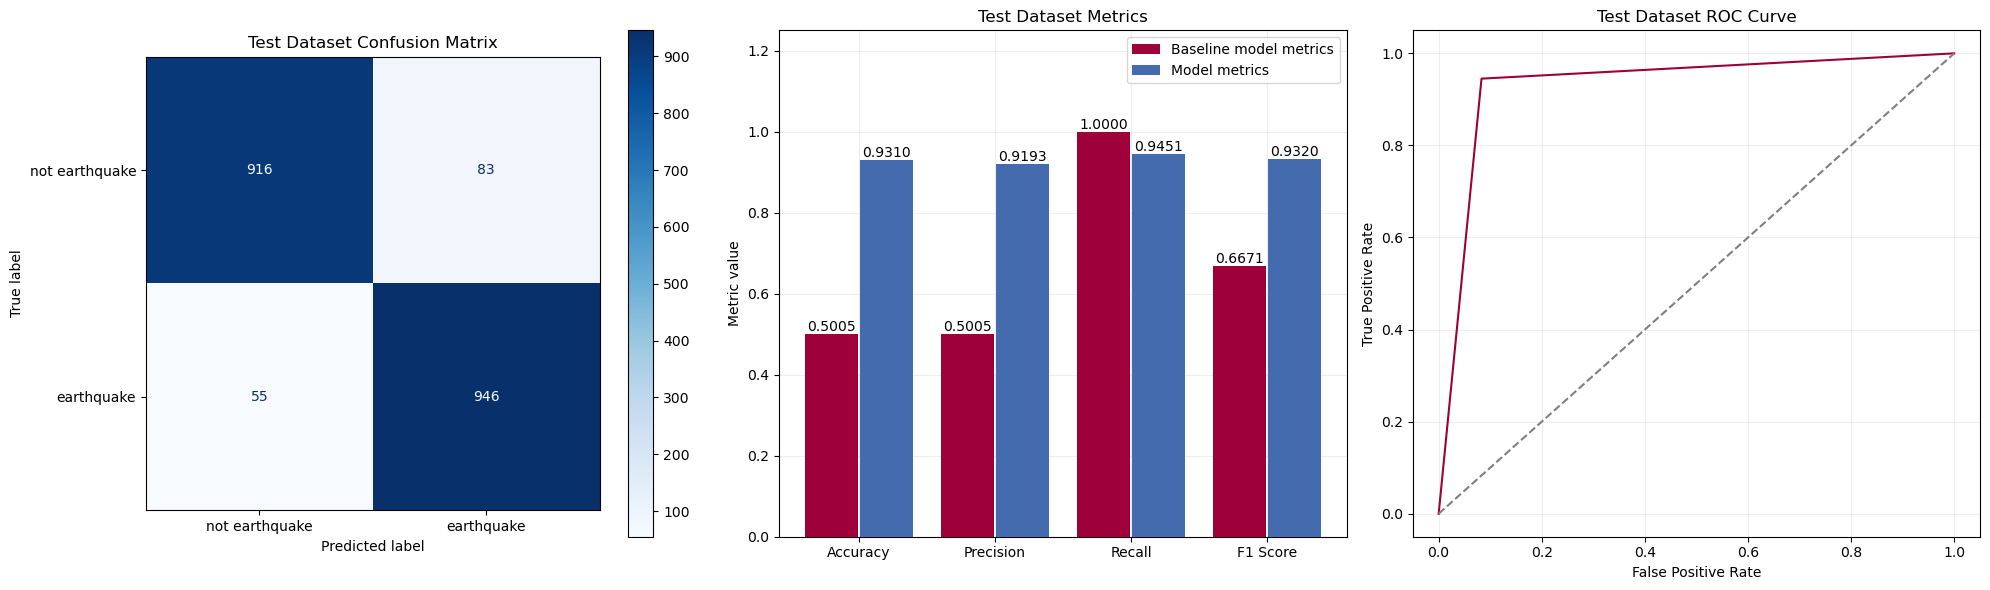

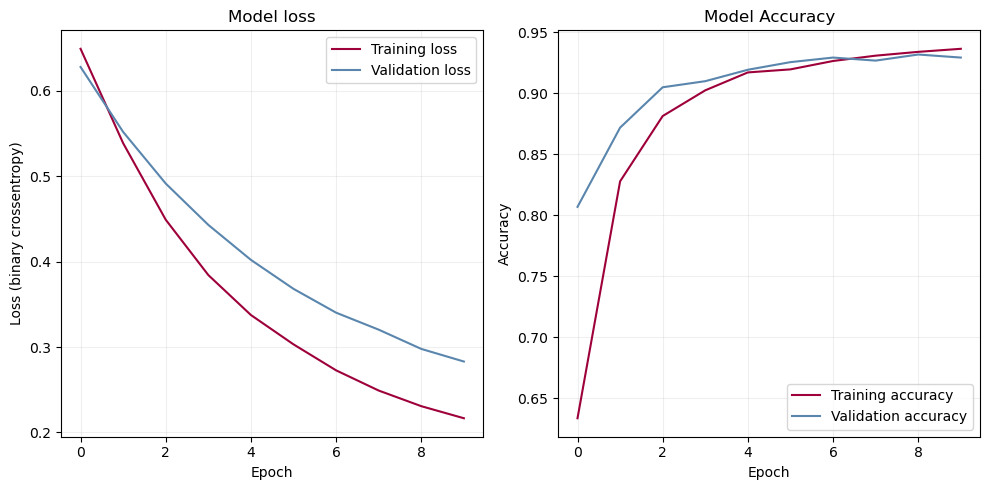

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 50, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 59200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,577,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,895,909 (87.34 MB)

 Trainable params: 7,631,969 (29.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,263,940 (58.23 MB)

In [11]:
# Set up model callbacks
epochs = 10
callbacks_c = architectures.callbacks_setup(model_tag='cnn_classification', epochs=epochs)

# Fit model
train_dataset_c, val_dataset_c, test_dataset_c = training_utils.prepare_datasets(imgs=spectrogram_imgs, labels=classifier_labels, preproc_func=architectures.image_preprocessing, preproc_func_kwargs=spectrogram_kwargs, batch_size=32)
classifier_model = architectures.build_compile_classification_cnn(learning_rate=1e-6, loss='binary_crossentropy', metrics=['accuracy'])
classifier_history = classifier_model.fit(train_dataset_c, epochs=epochs, callbacks=callbacks_c, validation_data=val_dataset_c)

# Evaluate model and plot results
training_utils.evaluate_classification_model(classifier_model, train_dataset_c, test_dataset_c)
training_utils.plot_training_history(classifier_history)
classifier_model.summary()

### 2. Regression CNN model training & evaluation to predict earthquake magnitude

In [ ]:
epochs = 10
callbacks_mag = architectures.callbacks_setup(model_tag='cnn_regression_magnitude', epochs=epochs)

labels = np.array(metadata_earthquakes_only['source_magnitude'])
train_dataset_mag, val_dataset_mag, test_dataset_mag = training_utils.prepare_datasets(imgs=spectrogram_imgs_earthquakes_only, labels=labels, preproc_func=architectures.image_preprocessing, preproc_func_kwargs=spectrogram_kwargs, use_scaler=False, batch_size=64)
model_magnitude = architectures.build_compile_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae'])
model_magnitude_history = model_magnitude.fit(train_dataset_mag, epochs=epochs, callbacks=callbacks_mag, validation_data=val_dataset_mag)

training_utils.evaluate_regression_model(model_magnitude, train_dataset_mag, test_dataset_mag, 'Source Magnitude', scaler=None)
training_utils.plot_training_history(model_magnitude_history)
model_magnitude.summary()

Epoch 1/10
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - loss: 1.5011 - mae: 0.9406

### 3. Regression CNN model training & evaluation to predict earthquake P-wave arrival time

In [ ]:
# Set up model callbacks
epochs = 10
callbacks_pwave = architectures.callbacks_setup(model_tag='cnn_regression_pwave', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['p_arrival_sample'])
train_dataset_pwave, val_dataset_pwave, test_dataset_pwave = training_utils.prepare_datasets(imgs=waveform_imgs_earthquakes_only, labels=labels, preproc_func=architectures.image_preprocessing, preproc_func_kwargs=waveform_kwargs, use_scaler=False, batch_size=32)
model_pwave = architectures.build_compile_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae'])
model_pwave_history = model_pwave.fit(train_dataset_pwave, epochs=epochs, callbacks=callbacks_pwave, validation_data=val_dataset_pwave)

# Evaluate model
training_utils.evaluate_regression_model(model_pwave, train_dataset_pwave, test_dataset_pwave, 'P-Wave Arrival', scaler=None)
training_utils.plot_training_history(model_pwave_history)
model_pwave.summary()

### 4. Regression CNN model training & evaluation to predict earthquake S-wave arrival time

In [ ]:
# Set up model callbacks
epochs = 10
callbacks_swave = architectures.callbacks_setup(model_tag='cnn_regression_swave', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['s_arrival_sample'])
train_dataset_swave, val_dataset_swave, test_dataset_swave = training_utils.prepare_datasets(imgs=waveform_imgs_earthquakes_only, labels=labels, preproc_func=architectures.image_preprocessing, preproc_func_kwargs=waveform_kwargs, use_scaler=False, batch_size=32)
model_swave = architectures.build_compile_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae'])
model_swave_history = model_swave.fit(train_dataset_swave, epochs=epochs, callbacks=callbacks_swave, validation_data=val_dataset_swave)

# Evaluate model
training_utils.evaluate_regression_model(model_swave, train_dataset_swave, test_dataset_swave, 'S-Wave Arrival', scaler=None)
training_utils.plot_training_history(model_swave_history)
model_swave.summary()

### 5. Regression CNN model training & evaluation to predict earthquake source-receiver distance (km)

In [ ]:
# Set up model callbacks
epochs = 10
callbacks_dist = architectures.callbacks_setup(model_tag='cnn_regression_distance', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['source_distance_km'])
train_dataset_dist, val_dataset_dist, test_dataset_dist = training_utils.prepare_datasets(imgs=spectrogram_imgs_earthquakes_only, labels=labels, preproc_func=architectures.image_preprocessing, preproc_func_kwargs=waveform_kwargs, use_scaler=False, batch_size=32)
model_distance = architectures.build_compile_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae'])
model_distance_history = model_distance.fit(train_dataset_dist, epochs=epochs, callbacks=callbacks_dist, validation_data=val_dataset_dist)

# Evaluate model
training_utils.evaluate_regression_model(model_distance, train_dataset_dist, test_dataset_dist, 'Source-Receiver Distance (km)', scaler=None)
training_utils.plot_training_history(model_distance_history)
model_distance.summary()

### 6. Regression CNN model training & evaluation to predict earthquake depth (km)

In [ ]:
# Set up model callbacks
epochs = 10
callbacks_depth = architectures.callbacks_setup(model_tag='cnn_regression_depth', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['source_depth_km'])
train_dataset_depth, val_dataset_depth, test_dataset_depth = training_utils.prepare_datasets(imgs=spectrogram_imgs_earthquakes_only, labels=labels, preproc_func=architectures.image_preprocessing, preproc_func_kwargs=waveform_kwargs, use_scaler=False, batch_size=32)
model_depth = architectures.build_compile_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae'])
model_depth_history = model_depth.fit(train_dataset_depth, epochs=epochs, callbacks=callbacks_depth, validation_data=val_dataset_depth)

# Evaluate model
training_utils.evaluate_regression_model(model_depth, train_dataset_depth, test_dataset_depth, 'Source Depth (km)', scaler=None)
training_utils.plot_training_history(model_depth_history)
model_depth.summary()